# Classification Lab
## Support Vector Machine

In this practice we will have two tasks: 
* Experiment with linear support vector machine
* Classify images in CIFAR10 dataset with KNN classifer and SVM 

Let's start!

# Warm up

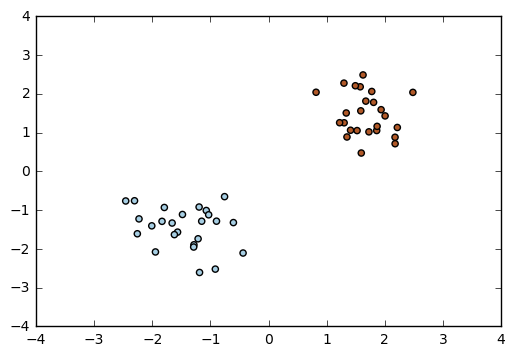

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from skimage.feature import hog

# Let's generate some 2D data
n_samples = 50
n_features = 2
centers = np.array([[-1.5, -1.5], [1.5, 1.5]])
random_state = 0
cluster_std = 0.5
X, Y = make_blobs(n_samples, n_features, centers, cluster_std, random_state)

# plot the data
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
plt.axis('tight')
plt.axis([-4, 4, -4, 4])
plt.show()

In [88]:
# Now, let's fit a linear SVM to the data
# This week we use the LinearSVC function from sklearn. You will implement your own Linear SVM in the next week.
def fitSVM(X, Y, C=1000):
    clf = LinearSVC(C=C) #hard margin
    clf.fit(X, Y)
    w = clf.coef_
    b = clf.intercept_
    return w,b,clf

w,b,_ = fitSVM(X,Y)
print('w: ', w)
print('b: ', b)

w:  [[ 0.66147145  0.39411871]]
b:  [-0.24284085]


# Task 1: Understand linear SVM
## We will do a list of interesting experiments with the above linear SVM classifier

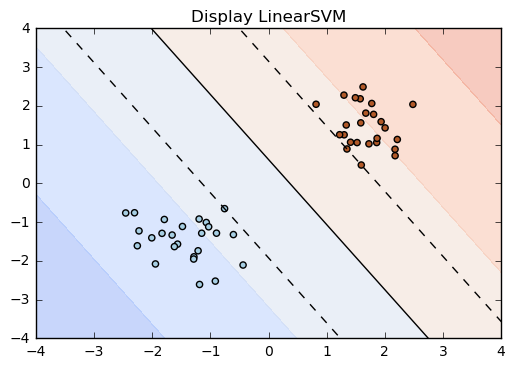

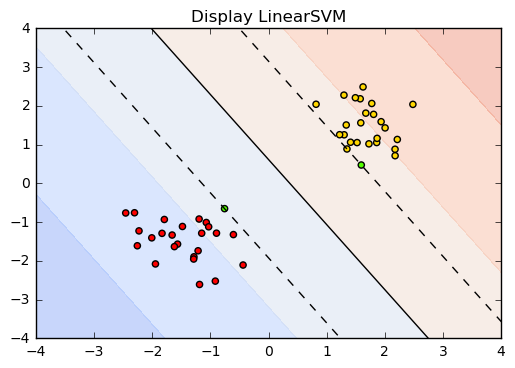

functional/geometric margin:  0.999774970942 1.29843747955
functional/geometric margin with w=w*2:  1.75670908695 1.14074516039


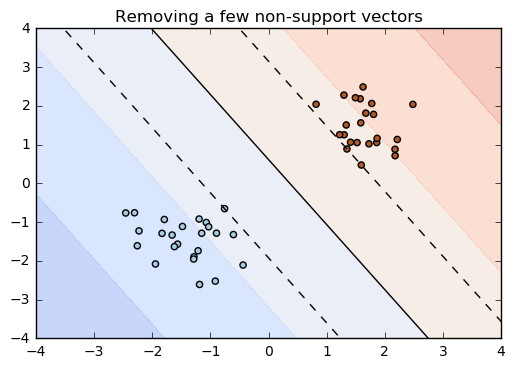

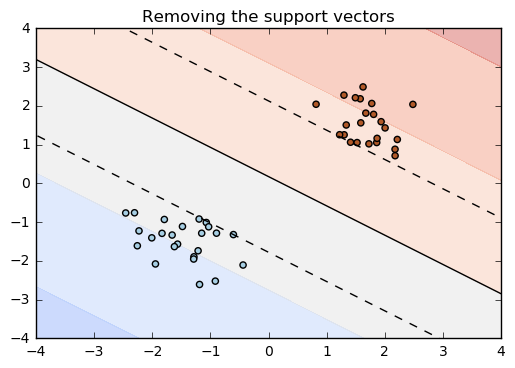

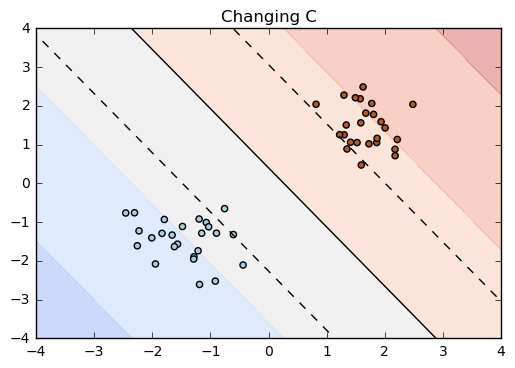

In [89]:
def plotSVM(X,Y,w,b,cmap,title = 'Display LinearSVM'):
    # Let's first visualize the results
    xx, yy = np.meshgrid(np.arange(-5, 5, 0.1), np.arange(-5, 5, 0.1))
    zz = np.dot(np.c_[xx.ravel(), yy.ravel()], w.T) + b # This is how we compute the classification score
    zz = zz.reshape(xx.shape)
    
    levels = [-1.0, 0, 1.0]
    linestyles = ['dashed', 'solid', 'dashed']
    colors = 'k'
    
    # the contourf function plot the "height map" of the classification score
    plt.contourf(xx, yy, zz, cmap=plt.cm.coolwarm, alpha = 0.4) # this is a color map that renders the classification score
    plt.contour(xx, yy, zz, levels, colors=colors, linestyles = linestyles) # These are the gutters of the street
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=cmap)
    plt.axis('tight')
    plt.axis([-4, 4, -4, 4])
    plt.title(title)
    plt.show()

plotSVM(X,Y,w,b, "Paired")

################################################################################
# TODO: Implement Match_L2(test, train)                                        #
################################################################################
# Experiment 1:
# Find the support vectors in X, and plot them in the figure 
# Hint: 
# 1) in practice, the support vectors may not exactly land on the gutters of the street.
# You can use a small epsilon to count for such discrepancy.
classScores = np.dot(X, w.T) + b
a = 1
indSup = np.where(np.logical_and(classScores >= -1, classScores <= 1))[0]
c=np.copy(Y)
c[indSup[0]] = 2
c[indSup[1]] = 2


plotSVM(X,c,w,b, "prism")


# 2) You can use plt.scatter to plot the support vectors. For example, plt.scatter(SV[:, 0], SV[:, 1], s=80, facecolors='none'))
# Question 1: What is the functional margin for this model? What is the geometric margin?
fMargin = np.min(classScores[:,0]*(Y-0.5)*2) #functional margin
gMargin = fMargin / np.sqrt(np.sum(w**2))#geometric margin
print("functional/geometric margin: ",fMargin, gMargin)

# Question 2: Let's multiply w by 2. What is the new functional margin and geometric margin? 
#             And what is the new geometric margin between the line wx + b = 1 and wx + b = -1? 
classScores2 = np.dot(X, (w*2).T) + b
fMargin2 = np.min(classScores2[:,0]*(Y-0.5)*2) #functional margin
gMargin2 = fMargin2 / np.sqrt(np.sum((w*2)**2))#geometric margin
print("functional/geometric margin with w=w*2: ",fMargin2, gMargin2)


# Experiment 2:
# Remove some non-support vectors from X and re-train the SVM, see if the model changes
removeNotSup = np.array(list(set([1,2,3])-(set(indSup))))
X2 = np.array([X[i] for i in range(50) if not i in removeNotSup])
Y2 = np.array([Y[i] for i in range(50) if not i in removeNotSup])
w2,b2,_ = fitSVM(X2,Y2)
plotSVM(X2,Y2,w2,b2,"Paired",title = "Removing a few non-support vectors")


# Experiment 3:
# Let's get back the full training set X. 
# This time, remove the support vectors from X and see if the result changes
X3 = np.array([X[i] for i in range(50) if not i in indSup])
Y3 = np.array([Y[i] for i in range(50) if not i in indSup])
w3,b3,_ = fitSVM(X3,Y3)
plotSVM(X3,Y3,w3,b3,"Paired", title = "Removing the support vectors")

# Experiment 4: Soft Margin
# Let's get back the full training set X. 
# The parameter C in the above line "clf = LinearSVC(C=1000)" controls how strict the SVM is
# See how the result change with larger/smaller C
w4,b4,_ = fitSVM(X,Y, C=1)
plotSVM(X,Y,w4,b4,"Paired", title="Changing C")

# ################################################################################
# #                                 END OF YOUR CODE                             #
# ################################################################################

# Task 2: Classify CIFAR10 with Linear SVM on Pixels

In [1]:
# Let's load our favouriate cifar10 dataset
from sklearn.svm import LinearSVC
from notebooks.utils.data_utils import load_CIFAR10
cifar10_dir = 'data/datasets/cifar-10-batches-py'
print('Loading CIFAR10 ...')
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
print('Loaded')

# Let's keep only the first 1000 training images and the first 100 testing images for efficiency
# Feel free to test with more images when your code works.
num_training = 1000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
num_test = 100
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Loading CIFAR10 ...


Loaded


NameError: name 'np' is not defined

testing accuracy =  0.35 
 training accuracy =  0.999


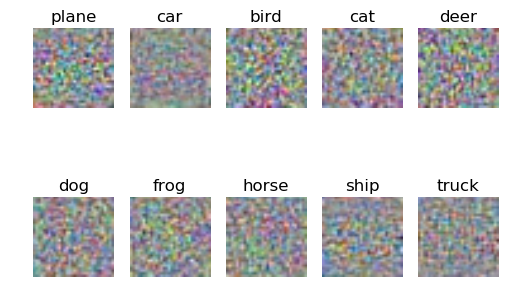

In [92]:
################################################################################
# TODO: Train a linear SVM using LinearSVC                                     #
################################################################################
# Step 1: Fit LinearSVC to X_train and y_train, use C = 1
# You should get around 0.22 testing accuracy (1000 training images and 100 testing images)
# It might take some time to train. (About a minute with a 2.5 GHz i7)
w,b,clf = fitSVM(X_train, y_train,C=1)
testACC = clf.score(X_test,y_test)
trainACC = clf.score(X_train,y_train)

print("testing accuracy = ", testACC, "\n training accuracy = ",trainACC)

# ################################################################################
# #                                 END OF YOUR CODE                             #
# ################################################################################
# Here is a way to visualize the learned weights. 

w = w.reshape(10, 32, 32, 3)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
plt.show()

# Question: Can you give a very intuitive explaination for these weight images from the perspective of image match?
#multiple examples for each class (each one different perspective/angle/color etc)

# Task 3: Classify CIFAR10 With Linear SVM on HOG

In [93]:
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.svm import LinearSVC
from notebooks.utils.data_utils import load_CIFAR10
cifar10_dir = 'data/datasets/cifar-10-batches-py'

def Vector2Image(v):
    return np.reshape(v, (32, 32, 3)).astype('uint8')

print('Loading CIFAR10 ...')
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
print('Loaded')

# Let's keep only the first 1000 training images and the first 100 testing images for efficiency
num_training = 1000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
num_test = 100
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Loading CIFAR10 ...


Loaded


Training data shape:  (1000, 3072)
Training labels shape:  (1000,)
Test data shape:  (100, 3072)
Test labels shape:  (100,)


In [110]:
################################################################################
# TODO: Train with HOG features                                                #
################################################################################
# Step 1: Compute HOG features for X_train and X_test
orientations=8
pixels_per_cell=(4, 4)
cells_per_block=(1, 1)
visualise=False

hog_X_train = np.array([hog(rgb2gray(Vector2Image(i)), orientations=orientations, pixels_per_cell=pixels_per_cell,
                    cells_per_block=cells_per_block, visualise=visualise) for i in X_train])
hog_X_test = np.array([hog(rgb2gray(Vector2Image(i)), orientations=orientations, pixels_per_cell=pixels_per_cell,
                    cells_per_block=cells_per_block, visualise=visualise) for i in X_test])

# Step 2: Train a linear SVM on HOG features, use C = 1
# It should train faster than pixels because the dimension of features is reduced
w,b,clf = fitSVM(hog_X_train, y_train,C=0.1)
testACC = clf.score(hog_X_test,y_test)
trainACC = clf.score(hog_X_train,y_train)

print("testing accuracy = ", testACC, "\n training accuracy = ",trainACC)

# Step 3: Test your classifier on both the training and testing set
# You should get around 0.28 testing accuracy with 1000 traninig image and the 100 testing images
# The testing accuracy should increase to around 0.42 with 20000 training images and 1000 teting images


################################################################################
#                                 END OF YOUR CODE                             #
################################################################################


################################################################################
# TODO: Try different C values for LinearSVC                                    #
################################################################################
# It seems that SVM does not generalize so well when trained with small data 
# (High accuracy on 1000 training images and low accuracy on 100 testing images).

# Let's improve it with better hyper-parameters.
# To do so, try to use different C values for the LinearSVC function.

# Question: How does the training/testing accuracy changes with C?
# C>0.1 results stay the same

# Question: what is the optimal C you found?
#C=0.01
#with testing accuracy =  0.31, training accuracy =  0.735

# Does it make the classifier more/less tolerant to miss-classification in the training data? 
# Can you explain your result?

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

/usr/lib/python3/dist-packages/skimage/feature/_hog.py:129: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  orientation_histogram[:, :, i] = temp_filt[subsample]


testing accuracy =  0.24 
 training accuracy =  0.933


# Task 4: Classify CIFAR10 With KNN on Pixel
## Now let's see how well does KNN classifier perform.

In [124]:
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.svm import LinearSVC
from notebooks.utils.data_utils import load_CIFAR10
cifar10_dir = 'data/datasets/cifar-10-batches-py'

def Vector2Image(v):
    return np.reshape(v, (32, 32, 3)).astype('uint8')

# With HOG features, the input dimension is reduced from 3072 to 512
# For these reason we can afford to train with more images
print('Loading CIFAR10 ...')
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
print('Loaded')
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Let's keep only the first 1000 training images and the first 100 testing images for efficiency
num_training = 1000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
num_test = 100
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

orientations=8
pixels_per_cell=(4, 4)
cells_per_block=(1, 1)
visualise=False
temp = hog(rgb2gray(Vector2Image(X_train[0])), orientations, pixels_per_cell,
                               cells_per_block, visualise)
temp = np.reshape(temp, (1, temp.shape[0]))

hog_train = np.zeros((X_train.shape[0], temp.shape[1]))
print("computing HOG features for training images ...")
for i in range(hog_train.shape[0]):
    hog_train[i, :] = hog(rgb2gray(Vector2Image(X_train[i, :])), orientations, pixels_per_cell,
                               cells_per_block, visualise)
print("finished")
hog_test = np.zeros((X_test.shape[0], temp.shape[1]))
print("computing HOG features for training images ...")
for i in range(hog_test.shape[0]):
    hog_test[i, :] = hog(rgb2gray(Vector2Image(X_test[i, :])), orientations, pixels_per_cell,
                               cells_per_block, visualise)
print("finished")

Loading CIFAR10 ...


Loaded
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


/usr/lib/python3/dist-packages/skimage/feature/_hog.py:129: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  orientation_histogram[:, :, i] = temp_filt[subsample]


computing HOG features for training images ...


finished
computing HOG features for training images ...


finished


In [129]:
from collections import Counter
from scipy import spatial
import heapq
from sklearn.metrics import confusion_matrix, accuracy_score
################################################################################
# TODO: Train a KNN classifier with Pixels                                     #
################################################################################
# You can build a KNN classifier based on the image match code you had done in the previous assignment

# Step 1: compute a distance matrices between X_test and X_train 
# Check the solution from last week for the VECTORIZED implementation for MULTIPLE testing images (Method 2).
X_dist = spatial.distance.cdist(X_test,X_train)

# Step 2: find the most frequent class in the top K = 5 neighbours for each testing image. 
# Hint, you can use the most_common function of the Counter class to return the most common class
# https://docs.python.org/2/library/collections.html#collections.Counter
K = 5

kNN_y_test = []
for i in range(len(X_test)):
    distances = X_dist[i]
    neighbors = heapq.nsmallest(K, range(len(distances)), distances.take)
    neighborClasses = y_train[neighbors]
    cnt = Counter(neighborClasses)
    
    kNN_y_test.append(cnt.most_common(1)[0][0])
    
kNN_y_test = np.array(kNN_y_test)
cnf_matrix = confusion_matrix(y_test, kNN_y_test)
acc = accuracy_score(y_test, kNN_y_test)
print("Accuracy: ",acc)
print("Confusion Matrix: ")
print(cnf_matrix)

# Compute the testing accuracy of your classifier
# You should get around 0.30 testing accuracy with k=5, 1000 traninig image, and 100 testing images

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

(100, 1000)


Accuracy:  0.24
Confusion Matrix: 
[[ 6  0  0  0  0  0  1  0  3  0]
 [ 0  0  0  0  1  0  2  0  3  0]
 [ 4  0  1  0  2  0  0  0  1  0]
 [ 2  0  1  0  3  0  3  0  0  1]
 [ 3  0  1  0  3  0  0  0  0  0]
 [ 1  0  4  1  1  0  0  0  1  0]
 [ 1  0  4  0  6  0  4  0  1  0]
 [ 1  1  2  2  1  0  1  0  3  0]
 [ 3  0  0  0  0  0  0  0 10  0]
 [ 1  0  1  0  1  0  1  0  7  0]]


/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


# Task 5: Classify CIFAR10 With KNN on HOG

In [128]:
from collections import Counter
################################################################################
# TODO: Train a KNN classifier with HOG features                               #
################################################################################
# You should get around 0.33 testing accuracy with k=5, 1000 traninig image, and 100 testing images

X_dist = spatial.distance.cdist(hog_test,hog_train)


# Step 2: find the most frequent class in the top K = 5 neighbours for each testing image. 
# Hint, you can use the most_common function of the Counter class to return the most common class
# https://docs.python.org/2/library/collections.html#collections.Counter
K = 5

kNN_y_test = []
for i in range(len(hog_test)):
    distances = X_dist[i]
    neighbors = heapq.nsmallest(K, range(len(distances)), distances.take)
    neighborClasses = y_train[neighbors]
    cnt = Counter()
    for neighbor in neighborClasses:
        cnt[neighbor] += 1
    kNN_y_test.append(cnt.most_common(1)[0][0])
    
kNN_y_test = np.array(kNN_y_test)
cnf_matrix = confusion_matrix(y_test, kNN_y_test)
acc = accuracy_score(y_test, kNN_y_test)
print("Accuracy: ",acc)
print("Confusion Matrix: ")
print(cnf_matrix)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Accuracy:  0.2
Confusion Matrix: 
[[ 0  2  0  0  1  0  5  0  2  0]
 [ 0  2  0  0  1  0  2  0  1  0]
 [ 0  0  1  0  2  1  2  0  1  1]
 [ 0  1  0  0  2  0  7  0  0  0]
 [ 0  0  3  1  0  0  2  0  1  0]
 [ 0  0  0  0  2  0  6  0  0  0]
 [ 1  0  2  0  2  0 11  0  0  0]
 [ 0  0  1  0  3  0  6  1  0  0]
 [ 0  0  1  1  2  0  3  1  5  0]
 [ 0  1  1  0  5  0  1  1  2  0]]


/usr/local/lib/python3.4/dist-packages/numpy/core/fromnumeric.py:2699: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)
